In [34]:
import qcomplexity as qc
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import minimize
import numpy as np

np.set_printoptions(linewidth=100000)

In [35]:
# Plots the geodesic curve along the unitary manifold, starting at some initial set of parameters and pointing in the direction of a
# tangent vector

inertia = jnp.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.1, 0.0],
    [0.0, 0.0, 0.1]
])

metric = jax.jit(qc.numerical_metric(inertia, qc.ham_fn)) # Metric tensor
christoffel_symbols = jax.jit(qc.numerical_christoffel_symbols(metric)) # Christoffel symbols

In [36]:
# The right-hand side of the geodesic differential equation
diff_fn = lambda *args : jnp.real(qc.diff_fn(christoffel_symbols)(*args))

In [37]:
# We can now solve the boundary value problem yielded form the geodesic equations

def batch_diff_fn(y1, y2):
    """Returns a batch of diff_fn evaluations"""
    return np.array([diff_fn(a, b) for a, b in zip(y1.T, y2.T)]).T

def prepare_guess(init, fin, steps):
    """Prepares initial guess for a given set of initial + final params"""
    first_rows = np.linspace(init, fin, steps).T
    second_rows = np.tile(fin - init, (steps, 1)).T
    return np.vstack([first_rows, second_rows])

In [369]:
nodes = 20 # Number of nodes for BVP solver to use
init = jnp.array([0.0, 0.0, 0.0], dtype=complex)
fin = jnp.array([0.65, 0.65, 0.0], dtype=complex) # Boundary condition
x = np.linspace(0, 1, nodes)

x_guess = prepare_guess(init, fin, nodes) # Initial solution guess

In [370]:
# Boundary conditions penalty
def bc(ya, yb):
    return np.array([ya[0:3] - init, yb[0:3] - fin]).flatten()

# BVP function
def f(x, y):
    s = y.shape[1]
    y = y.reshape(2, 3, s)
    #print(np.real(batch_diff_fn(y[0], y[1])))
    v = np.vstack((
        y[1], 
        -batch_diff_fn(y[0], y[1])
    )).reshape(6, s)
    #print(v)
    return v

In [371]:
res = solve_bvp(f, bc, x, x_guess, verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 1.06e+00 
Maximum boundary residual: 0.00e+00


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


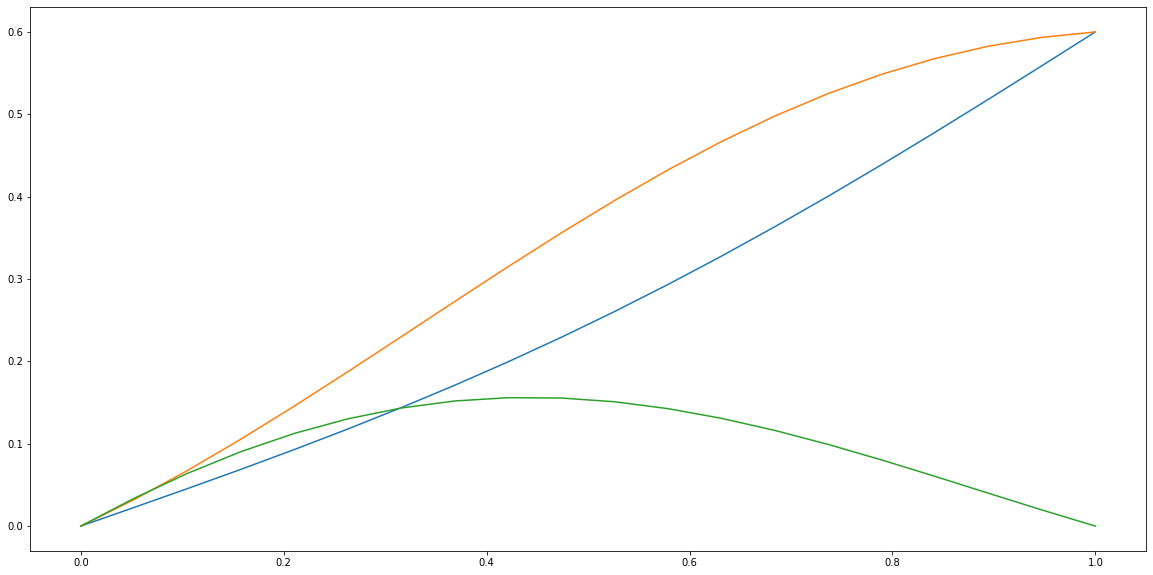

In [364]:
plt.figure(figsize=(20, 10))

plt.plot(x_plot, res.sol(x_plot)[0])
plt.plot(x_plot, res.sol(x_plot)[1])
plt.plot(x_plot, res.sol(x_plot)[2])

In [365]:
x_guess = res.sol(x)

In [33]:
for t in np.linspace(1, 2, 100):
    def bc(ya, yb):
        return np.array([ya[0:3] - init, yb[0:3] - t * fin]).flatten()
    res = solve_bvp(f, bc, x, x_guess, verbose=2)
    x_plot = np.linspace(0, 1, 20)
    y_plot = res.sol(x_plot)
    
    print(qc.length(metric, x_guess[0:3].T, x_guess[3:6].T, 1/20))
    x_guess = y_plot

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.49e-06       1.42e-24          20              0       
Solved in 1 iterations, number of nodes 20. 
Maximum relative residual: 6.49e-06 
Maximum boundary residual: 1.42e-24
(0.33765373-3.4616374e-09j)
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.97e-05       1.94e-06          20              0       
Solved in 1 iterations, number of nodes 20. 
Maximum relative residual: 2.97e-05 
Maximum boundary residual: 1.94e-06
(0.304002+8.599772e-10j)
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 2.97e-05 
Maximum boundary residual: 4.95e-03
(0.3064763+7.665142e-10j)
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iter

KeyboardInterrupt: 